In [1]:
import numpy as np
import pandas as pd
import pickle
from customized import preprocess
from customized import metrics
from customized.model import temporal_context_models

In [2]:
prod = pd.read_pickle('data/prod.pkl')
txn = pd.read_pickle('data/txn.pkl')
cmt = pd.read_pickle('data/cmt.pkl')
end_date = '2021-11-01' # 半年 # 下一場次是2021-11-02

### Filter non-popular streamers

In [3]:
txn.user_id.value_counts() # 4123: 蔥媽媽; 4460: 寵物

6835     2514491
6897     1414138
10891    1114931
12235     170198
4793      167510
6112      155526
27343     113286
4460       42634
4123        3718
Name: user_id, dtype: int64

In [4]:
sub_txn = txn[txn.user_id.isin(['10891','12235','6112','6835','6897','4460','4793'])]
sub_txn.user_id.value_counts()
streamer_static_fname='streamer_static_features_7.csv'
# streamer_static_fname='streamer_static_features_9.csv'

# Temporal Context Modeling

## Customer-Streamer Model (t=5 best)

In [5]:
rfm, static_df = preprocess.generate_static_user_context(sub_txn, end_date)
streamer = preprocess.generate_streamer_features(streamer_static_fname, sub_txn, prod, cmt, rfm, end_date) # 製作streamer features
scale_streamer = preprocess.standardize(streamer)     # 標準化

Sequence legth:  5 Batch size: 32
付款單號不等於t筆: 0
(37442, 115)
(25086, 115) (12356, 115) (25086,) (12356,)
Epoch [5/51], Step [784/784], Loss: 0.1812
Epoch [10/51], Step [784/784], Loss: 0.1398
Epoch [15/51], Step [784/784], Loss: 0.5217
Epoch [20/51], Step [784/784], Loss: 0.0464
Epoch [25/51], Step [784/784], Loss: 0.3042
Epoch [30/51], Step [784/784], Loss: 0.2160
Epoch [35/51], Step [784/784], Loss: 0.0862
Epoch [40/51], Step [784/784], Loss: 0.3182
Epoch [45/51], Step [784/784], Loss: 0.1294
Epoch [50/51], Step [784/784], Loss: 0.0293
Step [387/387], Loss: 0.0167
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3360
           1       0.86      0.80      0.83       815
           2       0.95      0.94      0.94       187
           3       0.91      0.94      0.93       536
           4       0.92      0.90      0.91       421
           5       0.95      0.96      0.96      2908
           6       0.94      0.96      0.95      

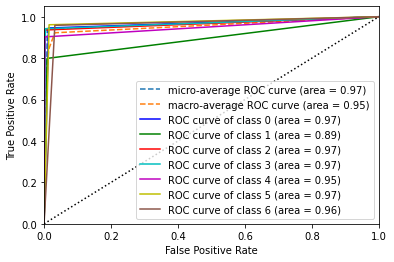

Sequence legth:  10 Batch size: 32
付款單號不等於t筆: 0
(19906, 230)
(13337, 230) (6569, 230) (13337,) (6569,)
Epoch [5/51], Step [417/417], Loss: 0.0746
Epoch [10/51], Step [417/417], Loss: 0.0973
Epoch [15/51], Step [417/417], Loss: 0.2996
Epoch [20/51], Step [417/417], Loss: 0.1003
Epoch [25/51], Step [417/417], Loss: 0.2911
Epoch [30/51], Step [417/417], Loss: 0.0103
Epoch [35/51], Step [417/417], Loss: 0.0574
Epoch [40/51], Step [417/417], Loss: 0.3687
Epoch [45/51], Step [417/417], Loss: 0.0340
Epoch [50/51], Step [417/417], Loss: 0.0395
Step [206/206], Loss: 0.4290
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1785
           1       0.82      0.76      0.79       295
           2       0.94      0.98      0.96        48
           3       0.92      0.96      0.94       294
           4       0.82      0.82      0.82       117
           5       0.96      0.95      0.95      1695
           6       0.95      0.95      0.95      2

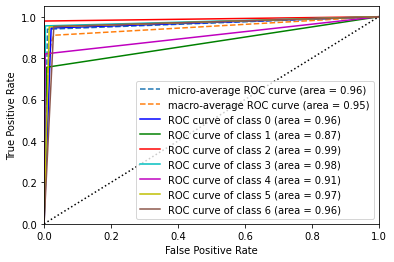

Sequence legth:  15 Batch size: 32
付款單號不等於t筆: 0
(11828, 345)
(7924, 345) (3904, 345) (7924,) (3904,)
Epoch [5/51], Step [248/248], Loss: 0.2917
Epoch [10/51], Step [248/248], Loss: 0.1303
Epoch [15/51], Step [248/248], Loss: 0.0479
Epoch [20/51], Step [248/248], Loss: 0.1833
Epoch [25/51], Step [248/248], Loss: 0.0792
Epoch [30/51], Step [248/248], Loss: 0.0141
Epoch [35/51], Step [248/248], Loss: 0.0080
Epoch [40/51], Step [248/248], Loss: 0.0080
Epoch [45/51], Step [248/248], Loss: 0.0062
Epoch [50/51], Step [248/248], Loss: 0.0281
Step [122/122], Loss: 0.0096
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1038
           1       0.72      0.77      0.74       149
           2       0.91      0.86      0.88        35
           3       0.89      0.97      0.93       159
           4       0.75      0.80      0.78        50
           5       0.95      0.95      0.95      1114
           6       0.95      0.94      0.95      135

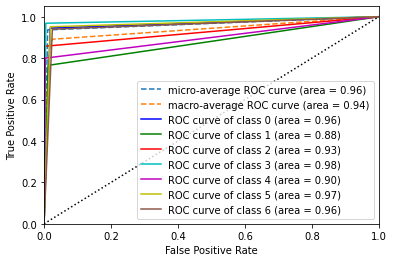

In [6]:
cs_model = temporal_context_models.CustomerStreamer(sub_txn, end_date, streamer, scale_streamer, static_df)
cs_loss_record, cs_epoch_loss, test_trues_bin, test_preds_bin = cs_model.train()

In [7]:
metrics.cal_remaining_metrics(test_trues_bin, test_preds_bin)

AUC (weighted): 0.9584
Precision (micro): 0.9365
Recall (micro):    0.9365
F1 score (micro):  0.9365



5 Sequences Training Loss : 0.2315
5 Sequences Validation Loss : 0.0468
10 Sequences Training Loss : 0.1803
10 Sequences Validation Loss : 0.3554
15 Sequences Training Loss : 0.0409
15 Sequences Validation Loss : 0.3448


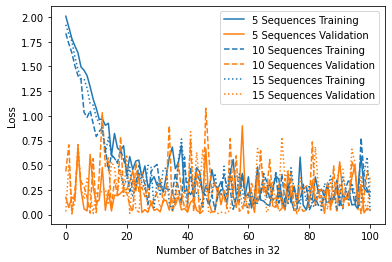

In [8]:
metrics.plot_loss_wt_val(cs_loss_record, x_max=101, x_label='Batches in 32', model_name='cs')

5 Sequences Training Loss : 0.0514
10 Sequences Training Loss : 0.1392
15 Sequences Training Loss : 0.0115


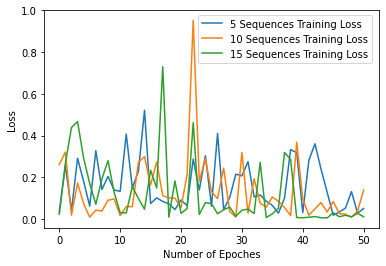

In [9]:
metrics.plot_loss_wo_val(cs_epoch_loss, x_max=51, model_name='tr_cs')

## Customer-Product Model (t=10 best)

In [10]:
cp_model = temporal_context_models.CustomerProduct(sub_txn, end_date, static_df)
cp_loss_record, cp_epoch_loss = cp_model.train()

Sequence length:  5 Batch size:  32
付款單號不等於t筆: 0
(37442, 3840) (37442, 768)
(25086, 3840) (12356, 3840) (25086, 768) (12356, 768)
Start training...
Epoch [5/11], Step [784/784], Loss: 0.0089
Epoch [10/11], Step [784/784], Loss: 0.0105
Step [387/387], Loss: 0.0077
Sequence length:  10 Batch size:  32
付款單號不等於t筆: 0
(19906, 7680) (19906, 768)
(13337, 7680) (6569, 7680) (13337, 768) (6569, 768)
Start training...
Epoch [5/11], Step [417/417], Loss: 0.0078
Epoch [10/11], Step [417/417], Loss: 0.0085
Step [206/206], Loss: 0.0056
Sequence length:  15 Batch size:  32
付款單號不等於t筆: 0
(11828, 11520) (11828, 768)
(7924, 11520) (3904, 11520) (7924, 768) (3904, 768)
Start training...
Epoch [5/11], Step [248/248], Loss: 0.0068
Epoch [10/11], Step [248/248], Loss: 0.0085
Step [122/122], Loss: 0.0065


5 Sequences Training Loss : 0.0074
5 Sequences Validation Loss : 0.0111
10 Sequences Training Loss : 0.0085
10 Sequences Validation Loss : 0.0092
15 Sequences Training Loss : 0.0079
15 Sequences Validation Loss : 0.007


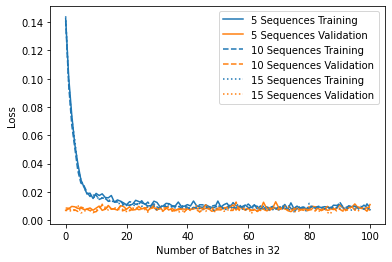

In [11]:
metrics.plot_loss_wt_val(cp_loss_record, x_max=101, x_label='Batches in 32', model_name='cp')

5 Sequences Training Loss : 0.01
10 Sequences Training Loss : 0.0083
15 Sequences Training Loss : 0.0086


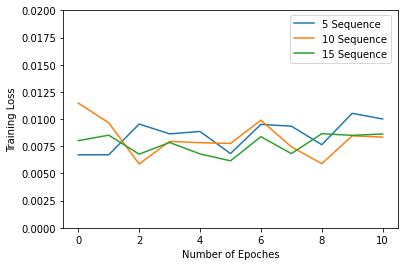

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
def plot_loss_wo_val(loss_record, x_max=26, model_name='tr_cs'):
    label_list = []
    for k,v in loss_record.items():  
        label_list.append(k[:-15])
        print(k,":", round(loss_record[k][x_max-1],4))
        plt.plot(range(len(loss_record[k])), loss_record[k][:x_max], label=k)
        plt.ylabel('Training Loss')
        plt.xlabel('Number of Epoches')
        plt.legend(labels=label_list, bbox_to_anchor=(.98, .98), loc=1, borderaxespad=0.)
        plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
#         plt.gca().set_xlim([xmin, xmax])
        ax.set_ylim([0, 0.02])
        plt.savefig(fname='./fig/loss_'+model_name+'_model.pdf', dpi=300, format='pdf', bbox_inches='tight')
    plt.show()
plot_loss_wo_val(cp_epoch_loss, x_max=11, model_name='tr_cp')

# Time intervals for purchase sequences

+ 2021-03-01~2021-11-01 8個月 top 3/14
+ 有的人頻率高到5次購買只間隔0天, 最長間隔244天(8個月), 平均間隔68天(2個多月)
+ 最早從 3/1 ~ 10/27開始, 3/1是top
+ 最晚從 3/2 ~ 11/1為止, 6/6是top

In [201]:
np.mean(prod_n.groupby('付款單號').商品id.count()) # 一張發票通常有幾個商品

4.897831002428608

In [18]:
t = 5
txn_t = preprocess.generate_last_n_txn(sub_txn, t, end_date)
a = txn_t[txn_t.seq == t][['asid','date']].set_index('asid').date.rename("a")
b = txn_t[txn_t.seq == 1][['asid','date']].set_index('asid').date.rename("b")
test = pd.concat([a,b], axis=1)
test['diff'] = (test.a - test.b).astype('timedelta64[D]')
test.describe()

付款單號不等於t筆: 0


,diff
count,37442.000000
mean,67.645665
std,44.966956
min,0.000000
25%,33.000000
50%,56.000000
75%,92.000000
max,244.000000


In [17]:
t = 10
txn_t = preprocess.generate_last_n_txn(sub_txn, t, end_date)
a = txn_t[txn_t.seq == t][['asid','date']].set_index('asid').date.rename("a")
b = txn_t[txn_t.seq == 1][['asid','date']].set_index('asid').date.rename("b")
test = pd.concat([a,b], axis=1)
test['diff'] = (test.a - test.b).astype('timedelta64[D]')
test.describe()

付款單號不等於t筆: 0


,diff
count,19906.000000
mean,103.816487
std,48.385181
min,0.000000
25%,65.000000
50%,98.000000
75%,137.000000
max,245.000000


In [22]:
t = 15
txn_t = preprocess.generate_last_n_txn(sub_txn, t, end_date)
a = txn_t[txn_t.seq == t][['asid','date']].set_index('asid').date.rename("a")
b = txn_t[txn_t.seq == 1][['asid','date']].set_index('asid').date.rename("b")
test = pd.concat([a,b], axis=1)
test['diff'] = (test.a - test.b).astype('timedelta64[D]')
test.describe()

付款單號不等於t筆: 0


,diff
count,11828.000000
mean,125.629692
std,47.925658
min,0.000000
25%,88.000000
50%,123.000000
75%,161.000000
max,241.000000


In [13]:
prod.describe(include=object) # 無用變數: name, kind

,id,name,category,kind,supplier,seller,user_id
count,280151,280151,13072,280151,4525,29390,280151
unique,280151,247092,280,2,142,33,9
top,7026407,316不鏽鋼陶晶煎烤盤(34公分)*1個,日常/生活用品,directbuy,鎮興五金,荳荳,10891
freq,1,93,909,280150,913,12971,169624


In [18]:
prod.describe(exclude=object) # 無用變數: quantity, cal_shipping_free_excluded

,price,quantity,weight,shipping_fee,cold_shipping,ship_alone,preorder,cal_shipping_free_excluded
count,2.801510e+05,2.801510e+05,280151.000000,280151,280151,280151,280151,280151
unique,NaN,NaN,NaN,2,2,2,2,2
top,NaN,NaN,NaN,True,False,False,False,False
freq,NaN,NaN,NaN,254185,279877,277867,280139,280133
mean,1.236125e+03,1.356087e+03,0.574369,NaN,NaN,NaN,NaN,NaN
std,1.932026e+04,2.975582e+05,1.779510,NaN,NaN,NaN,NaN,NaN
min,0.000000e+00,-1.241110e+05,0.000000,NaN,NaN,NaN,NaN,NaN
25%,1.850000e+02,-7.000000e+00,0.000000,NaN,NaN,NaN,NaN,NaN
50%,6.000000e+02,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,NaN
75%,1.480000e+03,2.000000e+01,0.000000,NaN,NaN,NaN,NaN,NaN


### Making t+1's agg features

In [61]:
prod_drop = prod.drop(columns=['name', 'kind', 'quantity', 'cal_shipping_free_excluded'])
prod_n_wt_feat = prod_n[prod_n.seq != (t+1)].merge(prod_drop, how='left', left_on='商品id', right_on='id').drop(columns='商品id')
def mode(x): m = pd.Series.mode(x); return m.values[0] if not m.empty else np.nan
basket_seq_feature = prod_n_wt_feat.groupby(['asid','seq']).agg(
    most_category = ('category', mode),
    avg_price = ('price', 'mean'),
    avg_weight = ('weight', 'mean'),
    avg_shipping_fee = ('shipping_fee', 'mean'),
    avg_cold_shipping = ('cold_shipping', 'mean'),
    avg_ship_alone = ('ship_alone', 'mean'),
    most_supplier = ('supplier', mode),
    most_seller = ('seller', mode),
    avg_preorder = ('preorder', 'mean'),
    most_user_id = ('user_id', mode)
)
basket_seq_feature
pd.to_pickle(basket_seq_feature,'data/basket_seq_feature.pkl')
# basket_seq_feature = pd.read_pickle('data/basket_seq_feature.pkl') # basket_seq_prods

most_category   avg_price  avg_weight  \
asid                              seq                                         
1000057940522534                  1             NaN  343.000000         0.0   
                                  2             NaN  149.333333         0.0   
                                  3             NaN  908.000000         0.0   
                                  4             NaN  490.400000         0.0   
                                  5             NaN  685.000000         0.0   
...                                             ...         ...         ...   
Ufd9f8919382ca4899c4090af496b7d8f 1             NaN  500.000000         0.0   
                                  2             NaN  500.000000         0.0   
                                  3             NaN  500.000000         0.0   
                                  4             NaN  500.000000         0.0   
                                  5             NaN  500.000000         0.0   

                                       avg_shipping_fee  avg_cold_shipping  \
asid                              seq                                        
1000057940522534                  1                 1.0                0.0   
                                  2                 1.0                0.0   
                                  3                 1.0                0.0   
                                  4                 1.0                0.0   
                                  5                 1.0                0.0   
...                                                 ...                ...   
Ufd9f8919382ca4899c4090af496b7d8f 1                 0.0                0.0   
                                  2                 0.0                0.0   
                                  3                 0.0                0.0   
                                  4                 0.0                0.0   
                                  5                 0.0                0.0   

                                       avg_ship_alone most_supplier  \
asid                              seq                                 
1000057940522534                  1               0.0           NaN   
                                  2               0.0           NaN   
                                  3               0.0           NaN   
                                  4               0.0           NaN   
                                  5               0.0           NaN   
...                                               ...           ...   
Ufd9f8919382ca4899c4090af496b7d8f 1               0.0           NaN   
                                  2               0.0           NaN   
                                  3               0.0           NaN   
                                  4               0.0           NaN   
                                  5               0.0           NaN   

                                      most_seller  avg_preorder most_user_id  
asid                              seq                                         
1000057940522534                  1           NaN         False        10891  
                                  2           NaN         False        10891  
                                  3           NaN         False        10891  
                                  4           NaN         False        10891  
                                  5           NaN         False        10891  
...                                           ...           ...          ...  
Ufd9f8919382ca4899c4090af496b7d8f 1            胖丁         False         4460  
                                  2            胖丁         False         4460  
                                  3            胖丁         False         4460  
                                  4            胖丁         False         4460  
                                  5            胖丁         False         4460  

[274700 rows x 10 columns]

In [9]:
basket_seq_feature.info() #= pd.read_pickle('data/basket_seq_feature.pkl')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 274700 entries, ('1000057940522534', 1) to ('Ufd9f8919382ca4899c4090af496b7d8f', 5)
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   most_category      29646 non-null   object 
 1   avg_price          274700 non-null  float64
 2   avg_weight         274700 non-null  float64
 3   avg_shipping_fee   274700 non-null  float64
 4   avg_cold_shipping  274700 non-null  float64
 5   avg_ship_alone     274700 non-null  float64
 6   most_supplier      1941 non-null    object 
 7   most_seller        22127 non-null   object 
 8   avg_preorder       274700 non-null  bool   
 9   most_user_id       274700 non-null  object 
dtypes: bool(1), float64(5), object(4)
memory usage: 23.4+ MB


In [3]:
from sklearn.preprocessing import LabelEncoder 
labelencoder = LabelEncoder()
for col in basket_seq_feature.columns:
    if 'most_' in col:
        print(col)
        basket_seq_feature[col] = labelencoder.fit_transform(basket_seq_feature[col])
basket_seq_feature